In [7]:
import os

import tensorflow as tf
import numpy as np
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
import scipy.misc
import sklearn
import cv2

print "Verzije"
print "Numpy - ",  np.__version__
print "OpenCV - ",  cv2.__version__
print "Scipy - " , scipy.__version__
print "Sklearn - ",  sklearn.__version__
print "Tensorflow - ",  tf.__version__
print "Matplotlib - ",  matplotlib.__version__

Verzije
Numpy -  1.12.0
OpenCV -  3.2.0
Scipy -  0.18.1
Sklearn -  0.18.1
Tensorflow -  0.12.1
Matplotlib -  2.0.0


# Original model bez fully connected layera
http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.svg

In [11]:
import tensorflow as tf
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import scipy.misc


def get_img(src, img_size=False):
    img = scipy.misc.imread(src, mode='RGB') # misc.imresize(, (224, 224, 3))
    if not (len(img.shape) == 3 and img.shape[2] == 3):
        img = np.dstack((img,img,img))
    if img_size != False:
        img = scipy.misc.imresize(img, img_size)
    return img

MEAN_PIXEL = np.array([ 123.68 ,  116.779,  103.939])

def net(data_path, input_image):
    layers = (
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

        'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
        'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

        'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
        'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

        'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
        'relu5_3', 'conv5_4', 'relu5_4',
        
        'pool5'
    )

    data = scipy.io.loadmat(data_path)
    mean = data['normalization'][0][0][0]
    mean_pixel = np.mean(mean, axis=(0, 1))
    weights = data['layers'][0]

    net = {}
    current = input_image
    for i, name in enumerate(layers):
        kind = name[:4]
        if kind == 'conv':
            kernels, bias = weights[i][0][0][0][0]
            # matconvnet: weights are [width, height, in_channels, out_channels]
            # tensorflow: weights are [height, width, in_channels, out_channels]
            kernels = np.transpose(kernels, (1, 0, 2, 3))
            bias = bias.reshape(-1)
            current = _conv_layer(current, kernels, bias)
        elif kind == 'relu':
            current = tf.nn.relu(current)
        elif kind == 'pool':
            current = _pool_layer(current)
        net[name] = current

    assert len(net) == len(layers)
    return net


def _conv_layer(input, weights, bias):
    conv = tf.nn.conv2d(input, tf.constant(weights), strides=(1, 1, 1, 1),
            padding='SAME')
    return tf.nn.bias_add(conv, bias)


def _pool_layer(input):
    return tf.nn.max_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
            padding='SAME')

def preprocess(image):
    return image - MEAN_PIXEL


def unprocess(image):
    return image + MEAN_PIXEL

(1, 224, 224, 3)


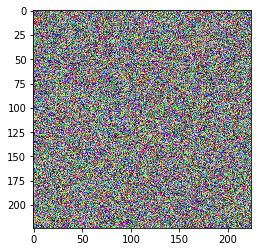

In [12]:
random_matrix = np.random.rand(1,224,224,3)
print random_matrix.shape
plt.imshow(random_matrix[0])
plt.show()

In [18]:
tf.reset_default_graph()

train_X = []
cnt = 0

with tf.Graph().as_default(), tf.device('/gpu:0'), tf.Session() as sess:
    VGG_PATH = '/home/user/fast-neural/imagenet-vgg-verydeep-19.mat'
    plac = tf.placeholder(tf.float32, [None,224,224,3])
    plac_preprocess = preprocess(plac)
    vgg = net(VGG_PATH, plac_preprocess)
    
    for root, dirs, files in os.walk("/home/user/Open_image/images_2016_08/train/images"):
        for name in files:
            file_path = os.path.join(root, name)
            img = cv2.imread(file_path)
            img = cv2.resize(img, (224,224))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            res = vgg['pool5'].eval(feed_dict={plac_preprocess:[img]})
            train_X.append(res.flatten())
            cnt+=1
            if cnt %1000 == 0:
                print("Processed %d" % cnt)
#vgg
#print 7*7*512
#res.shape

Processed 1000
Processed 2000
Processed 3000
Processed 4000
Processed 5000
Processed 6000
Processed 7000
Processed 8000
Processed 9000
Processed 10000
Processed 11000
Processed 12000
Processed 13000
Processed 14000
Processed 15000


In [19]:
train_X_np = np.array(train_X)
PCA_model = sklearn.decomposition.PCA()
PCA_model.fit(train_X_np)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [20]:
import cPickle
#save model
with open('/home/user/AVSP/PCA_15k.pkl', 'wb') as f:
    cPickle.dump(PCA_model, f)    

#load model
with open('/home/user/AVSP/PCA_15k.pkl', 'rb') as f:
    test = cPickle.load(f)

# Test PCA sa slicnim slikicama :D

In [51]:
similar_img = ""
similar_img_dist = float("inf")
cos_similar_img = ""
cos_similar_img_dist = float("inf")
test_path = '/home/user/Open_image/images_2016_08/train/images/0/002dbd19df89cddc.jpg'
cnt = 0
n_comp = 3000
num_test_img = 4000

with tf.Graph().as_default(), tf.device('/gpu:0'), tf.Session() as sess:
    VGG_PATH = '/home/user/fast-neural/imagenet-vgg-verydeep-19.mat'
    plac = tf.placeholder(tf.float32, [None,224,224,3])
    plac_preprocess = preprocess(plac)
    vgg = net(VGG_PATH, plac_preprocess)
    
    test_img = cv2.imread(test_path)
    test_img = cv2.resize(img, (224,224))
    test_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    test_img_vec = vgg['pool5'].eval(feed_dict={plac_preprocess:[img]})
    test_pca_vec = PCA_model.transform([test_img_vec.flatten()])[0][:n_comp]
    test_pca_cos = test_pca_vec / np.linalg.norm(test_pca_vec)
    
    for root, dirs, files in os.walk("/home/user/Open_image/images_2016_08/train/images"):
        for name in files:
            file_path = os.path.join(root, name)
            if file_path == test_path:
                print "Skipping test"
                continue
            img = cv2.imread(file_path)
            img = cv2.resize(img, (224,224))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            res = vgg['pool5'].eval(feed_dict={plac_preprocess:[img]})
            
            res_pca_vec = PCA_model.transform([res.flatten()])[0][:n_comp]    
            distance = np.linalg.norm(test_pca_vec-res_pca_vec)
            
            cos_distance = (test_pca_cos.dot(res_pca_vec))/np.linalg.norm(res_pca_vec)
            
            if distance < similar_img_dist:
                similar_img = file_path
                similar_img_dist = distance
                
            if cos_distance < cos_similar_img_dist:
                cos_similar_img = file_path
                cos_similar_img_dist = cos_distance
                
            cnt+=1
            if cnt %1000 == 0:
                print("Processed %d" % cnt)
            
            if cnt >= num_test_img:
                break
        if cnt >= num_test_img:
                break

Processed 1000
Processed 2000
Processed 3000
Processed 4000


/home/user/Open_image/images_2016_08/train/images/0/002dbd19df89cddc.jpg


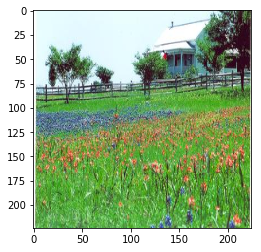

/home/user/Open_image/images_2016_08/train/images/618/0085982a5bea6b8a.jpg


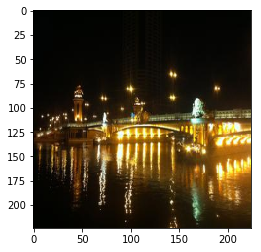

/home/user/Open_image/images_2016_08/train/images/864/003acb1a0c4cc471.jpg


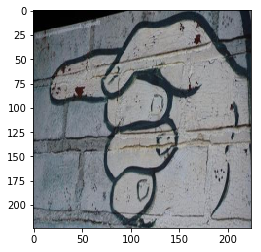

In [52]:
test_img = cv2.imread(test_path)
test_img = cv2.resize(test_img, (224,224))
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
print test_path
plt.imshow(test_img)
plt.show()


img = cv2.imread(similar_img)
img = cv2.resize(img, (224,224))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print similar_img
plt.imshow(img)
plt.show()

img = cv2.imread(cos_similar_img)
img = cv2.resize(img, (224,224))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print cos_similar_img
plt.imshow(img)
plt.show()

# Moje igranje da vidim kako je zapisan ostatak podataka iz .mat formata, zanemarite ovo dole

In [147]:
layers = (
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

        'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
        'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

        'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
        'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

        'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
        'relu5_3', 'conv5_4', 'relu5_4',
        
        'pool5'
    )
len(layers)

37

In [148]:
data = scipy.io.loadmat(VGG_PATH)

In [149]:
print data['layers'][0][37][0][0][0][0][0].shape #npr ovo bi bio fc6 layer weights
print data['layers'][0][37][0][0][0][0][1].shape #npr ovo bi bio fc6 layer bias

(7, 7, 512, 4096)
(1, 4096)
